# SVC

In [12]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.feature_selection import f_classif
import itertools
import sys
import importlib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
# from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis 
# from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
from joblib import Parallel, delayed, parallel_backend
from threadpoolctl import threadpool_limits
import matplotlib.pylab as plt
import os
from sklearn.inspection import permutation_importance
from scipy.stats import norm, t
from sklearn.base import clone 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

sys.path.append("../")
from proj_mod import training
importlib.reload(training);

## Data importing 

In [3]:
df=pd.read_csv("../data/raw.csv")
features=list(df.columns)[1:]
target=["Y"]
feat=df[features]
tar=df[target]
# x_t, x_v, y_t, y_v= train_test_split(feat,tar, test_size=0.2, random_state=0, stratify=tar["Y"])
n_splits=5

## For all raw features 

In [4]:
eva_pipe=Pipeline([("DataCreater", training.data_creator()),("DataSelector",training.data_selector())])
tar_arr=np.ravel(tar.values)
eva_pipe.fit(X=feat,y=tar)
eva_out=eva_pipe.transform(X=feat)
eva_out.columns

Index(['X1', 'X3', 'X5', 'X6', 'mean', 'F_w_mean', 'above_4', 'above_5'], dtype='object')

In [5]:
eva_pipe["DataSelector"].sel_

,features,f score,p value,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873,0.607460,0.834641,0.266199,0.492355,0.604855,0.280160
2,X3,2.886959,0.091807,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750,0.676149,0.532371,0.442280,0.638649,0.481689,0.150838
4,X5,6.582716,0.011488,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195,0.712786,0.806779,0.491804,0.616787,0.586695,0.224522
5,X6,3.586849,0.060568,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000,0.540096,0.574523,0.261704,0.458477,0.490605,0.167669
6,mean,7.306094,0.007836,0.607460,0.426097,0.676149,0.557803,0.712786,0.540096,1.000000,0.869373,0.687659,0.848710,0.773920,0.235885
7,F_w_mean,12.615311,0.000542,0.834641,0.078909,0.532371,0.298662,0.806779,0.574523,0.869373,1.000000,0.498831,0.743851,0.761327,0.303878
9,above_4,7.194813,0.008308,0.492355,0.268810,0.638649,0.521454,0.616787,0.458477,0.848710,0.743851,0.465645,1.000000,0.546995,0.234181
10,above_5,6.520675,0.011874,0.604855,0.215269,0.481689,0.389949,0.586695,0.490605,0.773920,0.761327,0.229256,0.546995,1.000000,0.223515


In [6]:
eva_pipe["DataSelector"].total_

,features,f score,p value,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873,0.607460,0.834641,0.266199,0.492355,0.604855,0.280160
1,X2,0.073108,0.787313,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205,0.426097,0.078909,0.500598,0.268810,0.215269,-0.024274
2,X3,2.886959,0.091807,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750,0.676149,0.532371,0.442280,0.638649,0.481689,0.150838
3,X4,0.516657,0.473623,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888,0.557803,0.298662,0.383442,0.521454,0.389949,0.064415
4,X5,6.582716,0.011488,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195,0.712786,0.806779,0.491804,0.616787,0.586695,0.224522
5,X6,3.586849,0.060568,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000,0.540096,0.574523,0.261704,0.458477,0.490605,0.167669
6,mean,7.306094,0.007836,0.607460,0.426097,0.676149,0.557803,0.712786,0.540096,1.000000,0.869373,0.687659,0.848710,0.773920,0.235885
7,F_w_mean,12.615311,0.000542,0.834641,0.078909,0.532371,0.298662,0.806779,0.574523,0.869373,1.000000,0.498831,0.743851,0.761327,0.303878
8,above_3,1.032794,0.311482,0.266199,0.500598,0.442280,0.383442,0.491804,0.261704,0.687659,0.498831,1.000000,0.465645,0.229256,0.090886
9,above_4,7.194813,0.008308,0.492355,0.268810,0.638649,0.521454,0.616787,0.458477,0.848710,0.743851,0.465645,1.000000,0.546995,0.234181


I am not sure at what dimension does our boundary live, so I will just use only the RBF kernel and skip the POLY kernel. 

In [8]:
range_feat_combin = training.all_combin(eva_out.columns)
kernel_choice = ["rbf"]
margin_choice = [100,10,1,0.1,0.01,0.001]

n_split = 5
n_repeats = 20
RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)
splits = list(RSKF.split(X=feat, y=tar))

pipe = Pipeline([
    ("DataCreate", training.data_creator()),
    ("DataSelector", training.data_selector()),
    ("Scaler", StandardScaler()),
    ("SVC", SVC())
    ])

jobs = list(itertools.product(range_feat_combin, kernel_choice, margin_choice))

Behold, all new pre-made evaluate_combo function for optimal cleanliness. 

In [13]:
results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(training.evaluate_combo)(
        list_f_sel_tuple=feat_sel, 
        dict_param={"SVC__kernel": kernel, 
                    "SVC__C": margin}, 
        splits=splits, 
        pipe=pipe, 
        feat=feat, 
        tar=tar
    )
    for feat_sel, kernel, margin in jobs
)

list_feat      = [r["features"] for r in results]
list_margin    = [r["SVC__C"] for r in results]
list_kernel    = [r["SVC__kernel"] for r in results]
list_acc_mean  = [r["acc_mean"] for r in results]
list_acc_std   = [r["acc_std"] for r in results]
list_f1_mean   = [r["f1_mean"] for r in results]
list_f1_std    = [r["f1_std"] for r in results]
list_above_73  = [r["above_73"] for r in results]
list_norm_above_73 = [r["norm_above_73"] for r in results] 
list_acc_mean_above_73 = [r["acc_mean_above_73"] for r in results]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [14]:
df_results = pd.DataFrame({
    #Hyper-parameters
    "features": list_feat,
    "margin": list_margin, 
    "kernel": list_kernel, 
    #Performances
    "acc_mean": list_acc_mean,
    "acc_std": list_acc_std,
    "f1_mean": list_f1_mean,
    "f1_std": list_f1_std,
    "above_73": list_above_73,
    "norm_above_73": list_norm_above_73, 
    "acc_mean_above_73": list_acc_mean_above_73
})

In [15]:
df_results.sort_values(by=["above_73"],ascending=False)

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
595,"X1,X3,X6,above_4",10.000,rbf,0.695954,0.090191,0.742027,0.076795,0.34,0.352904,0.000080
492,"X6,mean,F_w_mean",100.000,rbf,0.688415,0.102062,0.731973,0.087850,0.34,0.341841,0.000023
1153,"X1,X6,mean,F_w_mean,above_4",10.000,rbf,0.702938,0.086871,0.746194,0.076840,0.33,0.377705,0.000919
1051,"X1,X3,X6,F_w_mean,above_4",10.000,rbf,0.696646,0.084499,0.737082,0.076996,0.32,0.346524,0.000040
282,"X1,X6,mean",100.000,rbf,0.707831,0.076294,0.756336,0.068407,0.31,0.385687,0.001832
...,...,...,...,...,...,...,...,...,...,...
837,"X3,X6,mean,above_5",0.100,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
292,"X1,X6,F_w_mean",0.010,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
291,"X1,X6,F_w_mean",0.100,rbf,0.552769,0.041989,0.698754,0.046271,0.00,0.000012,0.000000
287,"X1,X6,mean",0.001,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000


In [16]:
df_results.sort_values(by=["acc_mean_above_73"],ascending=False)

,features,margin,kernel,acc_mean,acc_std,f1_mean,f1_std,above_73,norm_above_73,acc_mean_above_73
282,"X1,X6,mean",100.00,rbf,0.707831,0.076294,0.756336,0.068407,0.31,0.385687,0.001832
1153,"X1,X6,mean,F_w_mean,above_4",10.00,rbf,0.702938,0.086871,0.746194,0.076840,0.33,0.377705,0.000919
721,"X1,X6,F_w_mean,above_4",10.00,rbf,0.703431,0.081238,0.748624,0.069871,0.29,0.371814,0.000537
595,"X1,X3,X6,above_4",10.00,rbf,0.695954,0.090191,0.742027,0.076795,0.34,0.352904,0.000080
1051,"X1,X3,X6,F_w_mean,above_4",10.00,rbf,0.696646,0.084499,0.737082,0.076996,0.32,0.346524,0.000040
...,...,...,...,...,...,...,...,...,...,...
508,"X6,mean,above_5",0.01,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
507,"X6,mean,above_5",0.10,rbf,0.547692,0.016165,0.707611,0.013610,0.00,0.000000,0.000000
506,"X6,mean,above_5",1.00,rbf,0.569692,0.068949,0.676887,0.068387,0.00,0.010035,0.000000
505,"X6,mean,above_5",10.00,rbf,0.570015,0.073865,0.632869,0.081864,0.02,0.015159,0.000000


In [19]:
df_results.to_csv("../data/SVC_results_exhaust_raw6.csv", index=False) 

282 is my favorite. 

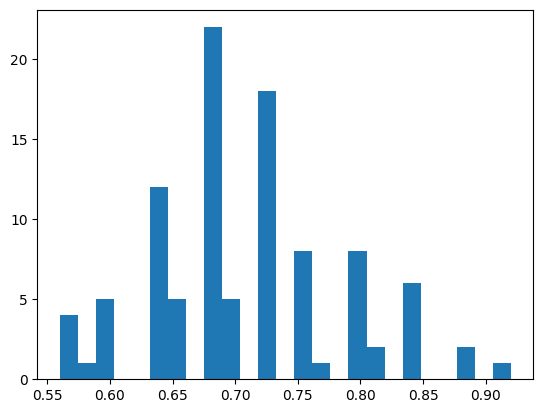

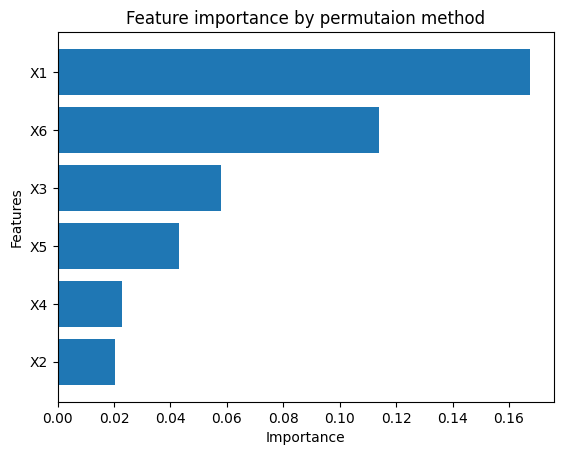

[[0.25041538 0.20189231]
 [0.09027692 0.45741538]]


In [18]:
n_split = 5 
n_repeats = 20
RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)
splits = list(RSKF.split(X=feat, y=tar))
pipe = Pipeline([
    ("DataCreate", training.data_creator()),
    ("DataSelector", training.data_selector(force=["X1","X6","mean"])),
    ("Scaler", StandardScaler()),
    ("SVC", SVC(kernel="rbf",C=100.00))
    ])
training.show_result(splits=splits,pipe=pipe,feat=feat,tar=tar)

X2 gotta go. 